# Dialogue Evaluation Tutorial

<p align="right" style="margin-right: 8px;">
    <a target="_blank" href="https://colab.research.google.com/github/idiap/sdialog/blob/main/tutorials/5.evaluation.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</p>

This tutorial shows how to evaluate LLM-generated dialogues against a real dataset (STAR). You will:

- Set up the environment (Colab or local Jupyter) and install dependencies
- Load the STAR dataset to serve as the reference
- Load several model-generated dialogue sets to compare
- Use an LLM-based judge to assess "realism" and collect feedback
- Compute additional metrics (dialog flow perplexity, frequency of realism, length stats, readability)
- Compare multiple datasets side-by-side and visualize the results

## Getting Started

### Environment setup

- Detects whether the notebook runs on Google Colab or local Jupyter.
- On Colab, it sparsely checks out only the `output` directory, installs Ollama, and installs `sdialog` in editable mode.
- On Jupyter, a small hack avoids background process limitations so Ollama can run as a daemon.

In [1]:
# Setup the environment depending on weather we are running in Google Colab or Jupyter Notebook
from IPython import get_ipython

if "google.colab" in str(get_ipython()):
    print("Running on CoLab")

    # Downloading only the "output" directory from the repository
    !git init .
    !git remote add -f origin https://github.com/Play-Your-Part/tutorials.git
    !git config core.sparseCheckout true
    !echo "output" >> .git/info/sparse-checkout
    !git pull origin main

    # Installing Ollama
    !curl -fsSL https://ollama.com/install.sh | sh
    %pip install simpleneighbors

    # Installing sdialog
    !git clone https://github.com/idiap/sdialog.git
    %cd sdialog
    %pip install -e .
    %cd ..
else:
    print("Running in Jupyter Notebook")
    # Little hack to avoid the "OSError: Background processes not supported." error in Jupyter notebooks"
    import os
    get_ipython().system = os.system

Running in Jupyter Notebook


### Dataset: STAR

We clone the STAR dataset into `datasets/STAR`. After cloning, you should see the `dialogues` and `tasks` folders. STAR provides human-written conversations grouped by task names; we will use it as the ground-truth reference for evaluation.

In [ ]:
# Let's clone the STAR dataset repository
!git clone https://github.com/RasaHQ/STAR.git datasets/STAR

# Let's check that `dialogues` and `tasks` folders are inside `datasets/STAR`
!ls datasets/STAR

### LLM backend and configuration

- Configure `sdialog` to use a local LLM served by Ollama and set the model to `gemma3:27b`.
- Start the Ollama server in the background and give it a few seconds to initialize.
- Point `sdialog.datasets.STAR` to the cloned dataset path so it can load dialogues.

In [ ]:
import sdialog

from sdialog.datasets import STAR

STAR_PATH = "datasets/STAR/"
STAR.set_path(STAR_PATH)

!OLLAMA_KEEP_ALIVE=-1 ollama serve > /dev/null 2>&1 &
!sleep 10

sdialog.config.llm("gemma3:27b")
# If you want to use another model, let's say OpenAI gpt-4, you can do, for instance:
# sdialog.config.llm("openai:gpt-4.1", api_key="YOUR_OPENAI_KEY")  # or set the key in the environment variable OPENAI_API_KEY

## Evaluation

### Evaluation overview

We will:
- Select a subset of STAR (reference) dialogues to define the target distribution.
- Load multiple generated dialogue sets to compare (single-LLM, multi-agent, orchestration, and an outlier set).
- Inspect samples, then score dialogues with an LLM-based judge and other metrics.
- Aggregate results and compare datasets side-by-side.
- Visualize the comparison to understand strengths and weaknesses.

### Reference dialogues

We use the `doctor_followup` task with `happy=True` and `multitask=False` as our reference set. This defines a focused domain and tone for evaluation—generated dialogues will be compared against this distribution.

In [4]:
original_dialogs = STAR.get_dialogs(task_name="doctor_followup", happy=True, multitask=False)
print('Total number of happy "doctor_followup" dialogues:', len(original_dialogs))

Reading dialogs:   0%|          | 0/6652 [00:00<?, ?it/s]

Total number of happy "doctor_followup" dialogues: 105


### Model outputs to compare

We load several sets of generated dialogues:
- `single-llm`: produced by a single LLM.
- `multi-agents`: produced by a multi-agent setup.
- `multi-agents+orchestration`: multi-agent with orchestration.
- `outlier`: a deliberately different dataset (Primock-57) as an outlier.

We also normalize speaker names (e.g., `doctor`→`system`, `patient`→`user`) so all datasets share the same speaker labels for fair comparison in case of `DialogFlowPPL` which consider speakers role.

In [5]:
from sdialog import Dialog

single_llm_dialogs = Dialog.from_file("output/STAR/full-generation/txt")
multi_agent_dialogs = Dialog.from_file("output/STAR/multi-agents/txt")
orche_dialogs = Dialog.from_file("output/STAR/multi-agents+orchestration/txt")
outlier_dialogs = Dialog.from_file("datasets/Primock-57/json/")
outlier_dialogs[:] = [d.rename_speaker("doctor", "system").rename_speaker("patient", "user")
                      for d in outlier_dialogs]

Loading dialogues from directory:   0%|          | 0/105 [00:00<?, ?it/s]

Loading dialogues from directory:   0%|          | 0/105 [00:00<?, ?it/s]

Loading dialogues from directory:   0%|          | 0/105 [00:00<?, ?it/s]

Loading dialogues from directory: 0it [00:00, ?it/s]

In [6]:
len(single_llm_dialogs)

105

### Inspect a sample dialogue

Printing one dialogue helps verify the structure (speaker turns, ordering, metadata) and content style. Ensure roles (`system`/`user`) and the flow align with expectations before running metrics.

In [7]:
single_llm_dialogs[0].print()

[dialog_id] 1
--- Dialogue Begins ---
[System] Hello, how can I help?
[User] Hi, could you please remind me of my doctor's instructions for the medicine?
[System] Could I get your name, please?
[User] My name is Alexis.
[System] Who is your doctor?
[User] I was seeing Dr. Morgan.
[System] Your instructions are: Take the medicine three times a day, 30 minutes before meals.
[User] Thank you, that's helpful.
[System] Is there anything else that I can do for you?
[User] No, that's all. Thank you.
[System] Thank you and goodbye.
--- Dialogue Ends ---


### LLM-based realism judge

`LLMJudgeRealDialog` prompts an LLM to assess whether a dialogue resembles a real human conversation for the given domain. It can return a judgment and optional textual feedback explaining the decision. The next cells demonstrate single-dialog evaluation with and without feedback, and then apply the same judge to other datasets.

In [8]:
from sdialog.evaluation import LLMJudgeRealDialog

judge_real = LLMJudgeRealDialog()

judge_real(single_llm_dialogs[0])

[2025-09-11 14:45:59] INFO:sdialog.util:Loading Ollama model: gemma3:27b


0

In [9]:
judge_real.judge(single_llm_dialogs[0])

LLMJudgeYesNoOutput(yes=False, feedback=None)

In [10]:
judge_real.judge(single_llm_dialogs[0], feedback=True)

LLMJudgeYesNoOutput(yes=False, feedback="The dialogue is very short and lacks depth. While coherent, it's a highly functional, transactional exchange without any of the nuances of a natural conversation (e.g., small talk, elaboration, or personal touches). The responses are direct and lack any conversational 'texture', making it feel artificial and likely machine-generated.")

In [11]:
orche_dialogs[0].print()

[dialog_id] 1
--- Dialogue Begins ---
[System] Hello, how can I help?
[User] Hi! Can you tell me again how often I should be taking my medication that Dr. Morgan prescribed? I seem to have forgotten and I want to make sure I’m doing it correctly.
[System] Could I get your name, please? And don't worry, I can help clarify the instructions for your medication.
[User] Of course, my name is Alexis. Thanks a lot for your help! Dr. Johnson was the one who gave me this prescription during my last visit, but I’m having trouble remembering the dosage details. Could you assist with that?
[System] Thank you for letting me know, Alexis. Who is your doctor? I see here it's Dr. Johnson providing your care. Let me confirm the instructions with him.
[User] Yes, my apologies! It was Dr. Johnson who prescribed the medication during my recent visit. While we're on the topic, do you happen to have any updates about my condition since then? I've been feeling a bit off lately and wasn't sure if it's related

In [12]:
judge_real(orche_dialogs[0])

0

In [13]:
judge_real.judge(orche_dialogs[0], feedback=True)

LLMJudgeYesNoOutput(yes=False, feedback="The dialogue feels synthetic due to its overly polite and formulaic exchanges. The responses from both sides are very direct and lack the natural imperfections or subtleties found in human conversation. The system repeats thanking the user and restating information unnecessarily. The user's attempt to introduce a related concern ('feeling a bit off') is met with a purely informational response, lacking empathy or further inquiry – a pattern unlikely in a human interaction. The whole exchange feels transactional rather than conversational.")

### Batch judging and caching

You can pass a list or slices (e.g., `dialogs[:3]`) to judge multiple dialogues at once. Enabling `sdialog.config.cache(True)` later helps avoid repeated LLM calls when re-running cells.

In [14]:
judge_real.judge(orche_dialogs[:3], feedback=True)

LLMJudgeYesNoOutput(yes=[True, True, True], feedback=["This dialogue demonstrates natural conversation flow, with the user expressing a need and the system responding appropriately. The repetition of confirming information ('Dr. Morgan', 'dosage details') is realistic. It has sufficient depth and demonstrates a genuine intent.", 'This dialogue is also very natural, mirroring a patient follow-up. The user clarifies their needs and the system responds. The back and forth about confirming details and dosages is realistic. It feels like a human interaction with a reasonable level of detail.', 'Similar to the other dialogues, this one exhibits natural conversational flow and a realistic scenario. The user expresses forgetfulness and the system helps. The exchange is not overly complex, but contains realistic elements like thanking the assistant and confirming the information received.'])

### Frequency of realism

`FrequencyEvaluator` uses the judge to compute how often dialogues are classified as "real" within a set. Compare values across datasets; closer to the reference distribution usually indicates better realism for the target task.

In [15]:
from sdialog.evaluation import FrequencyEvaluator

freq_real = FrequencyEvaluator(judge_real)

freq_real(single_llm_dialogs[:10])

Computing frequency-llm-judge-real-dialog scores for candidate dataset:   0%|          | 0/10 [00:00<?, ?it/s]

0.0

In [16]:
freq_real(orche_dialogs[:10])

Computing frequency-llm-judge-real-dialog scores for candidate dataset:   0%|          | 0/10 [00:00<?, ?it/s]

0.3

### Custom metrics

We define `DialogLength` to count the number of turns per dialogue. Later, `StatsEvaluator` will summarize this score (e.g., mean, std) across each dataset, highlighting length differences relative to the reference.

In [17]:
from sdialog.evaluation import BaseDialogScore

# Let's define a new dialog score to count the number of turns in a dialog 
class DialogLength(BaseDialogScore):
    def score(self, dialog: Dialog) -> int:
        return len(dialog)

### Configuring the dataset comparator

We assemble several evaluators:
- `KDEDistanceEvaluator(DialogFlowPPL)`: compares the distribution of dialog-flow perplexity to the reference (lower distance indicates closer behavior).
- `FrequencyEvaluator(LLMJudgeRealDialog)`: fraction of dialogues judged as realistic.
- `StatsEvaluator(DialogLength)`: summarizes turn counts.
- `MeanEvaluator(flesch-reading-ease)` and `MeanEvaluator(gunning-fog)`: readability indicators.

Caching is enabled to avoid re-computation next time the call is run.

In [18]:
import sdialog

from sdialog.evaluation import DatasetComparator
from sdialog.evaluation import DialogFlowPPL, LLMJudgeRealDialog, LinguisticFeatureScore
from sdialog.evaluation import KDEDistanceEvaluator, StatsEvaluator, FrequencyEvaluator, MeanEvaluator

sdialog.config.cache(True)

real_dialog_judge = LLMJudgeRealDialog(feedback=True)
dfppl = DialogFlowPPL(original_dialogs)
dialog_length = DialogLength(name="turn length")
flesch_reading_ease = LinguisticFeatureScore(feature="flesch-reading-ease")
gunning_fog = LinguisticFeatureScore(feature="gunning-fog")

comparator = DatasetComparator(
    evaluators=[
        KDEDistanceEvaluator(dfppl),
        FrequencyEvaluator(real_dialog_judge),
        StatsEvaluator(dialog_length),
        MeanEvaluator(flesch_reading_ease, name="Mean Flesch Reading Ease"),
        MeanEvaluator(gunning_fog, name="Mean Gunning Fog")
    ]
)

[2025-09-11 14:46:44] INFO:sdialog.config:Caching enabled. Cache path: ~/.sdialog/
[2025-09-11 14:46:44] WARNING:sdialog.config:Caution: Caching may cause outdated results if external or implicit variables affecting score computation are changed. For example, if you use LLMJudge-based scores without specifying the model (relying on the global default), the cache will return previous results even if the default model changes. To avoid inconsistencies, ensure all relevant parameters are explicitly set when caching is enabled.
Use with caution! ;)
[2025-09-11 14:46:44] INFO:sdialog.util:Loading Ollama model: gemma3:27b
[2025-09-11 14:46:44] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

[2025-09-11 14:46:47] INFO:sdialog.evaluation.dialog2flow.build_graph:Final graph contains 73 nodes after pruning and normalization.
[2025-09-11 14:46:47] INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
[2025-09-11 14:46:47] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sergioburdisso/dialog2flow-joint-bert-base


Computing reference kde-distance-dfppl scores:   0%|          | 0/105 [00:00<?, ?it/s]

### Running the comparison

The comparator expects a dictionary mapping labels to lists of `Dialog` objects. Include a `reference` key for the ground-truth set. The output aggregates all evaluator results so you can quickly spot which generated datasets best match the reference.

In [19]:
comparator({
    "reference": original_dialogs,
    "single-llm": single_llm_dialogs,
    "multi-agents": multi_agent_dialogs,
    "multi-agents+orchestration": orche_dialogs,
    "outlier": outlier_dialogs
})

Evaluating datasets:   0%|          | 0/5 [00:00<?, ?it/s]

Computing kde-distance-dfppl scores for dataset 'reference':   0%|          | 0/105 [00:00<?, ?it/s]

Computing frequency-llm-judge-real-dialog scores for dataset 'reference':   0%|          | 0/105 [00:00<?, ?it…

Computing stats-turn length scores for dataset 'reference':   0%|          | 0/105 [00:00<?, ?it/s]

Computing Mean Flesch Reading Ease scores for dataset 'reference':   0%|          | 0/105 [00:00<?, ?it/s]

Computing Mean Gunning Fog scores for dataset 'reference':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-distance-dfppl scores for dataset 'single-llm':   0%|          | 0/105 [00:00<?, ?it/s]

Computing frequency-llm-judge-real-dialog scores for dataset 'single-llm':   0%|          | 0/105 [00:00<?, ?i…

Computing stats-turn length scores for dataset 'single-llm':   0%|          | 0/105 [00:00<?, ?it/s]

Computing Mean Flesch Reading Ease scores for dataset 'single-llm':   0%|          | 0/105 [00:00<?, ?it/s]

Computing Mean Gunning Fog scores for dataset 'single-llm':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-distance-dfppl scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing frequency-llm-judge-real-dialog scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, …

Computing stats-turn length scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing Mean Flesch Reading Ease scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing Mean Gunning Fog scores for dataset 'multi-agents':   0%|          | 0/105 [00:00<?, ?it/s]

Computing kde-distance-dfppl scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00:00<?,…

Computing frequency-llm-judge-real-dialog scores for dataset 'multi-agents+orchestration':   0%|          | 0/…

Computing stats-turn length scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00:00<?, …

Computing Mean Flesch Reading Ease scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00…

Computing Mean Gunning Fog scores for dataset 'multi-agents+orchestration':   0%|          | 0/105 [00:00<?, ?…

Computing kde-distance-dfppl scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

Computing frequency-llm-judge-real-dialog scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

Computing stats-turn length scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

Computing Mean Flesch Reading Ease scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

Computing Mean Gunning Fog scores for dataset 'outlier':   0%|          | 0/57 [00:00<?, ?it/s]

| dataset                    |   kde-distance-dfppl |   frequency-llm-judge-real-dialog |   stats-turn length-mean |   stats-turn length-std |   stats-turn length-min |   stats-turn length-max |   stats-turn length-median |   Mean Flesch Reading Ease |   Mean Gunning Fog |
|:---------------------------|---------------------:|----------------------------------:|-------------------------:|------------------------:|------------------------:|------------------------:|---------------------------:|---------------------------:|-------------------:|
| reference                  |                 0.00 |                              0.00 |                     8.51 |                    2.56 |                    2.00 |                   16.00 |                       8.00 |                      -5.86 |              39.73 |
| single-llm                 |                 0.36 |                              0.00 |                     9.74 |                    1.33 |                    6.00 |          

### Visualizing results

`comparator.plot()` charts each metric across datasets. Look for:
- Lower KDE distance (closer to reference distribution)
- Higher frequency of realism (when appropriate)
- Reasonable dialogue lengths relative to reference
- Readability scores in a plausible range for the task

These views help diagnose which generation strategies perform best and where they diverge.

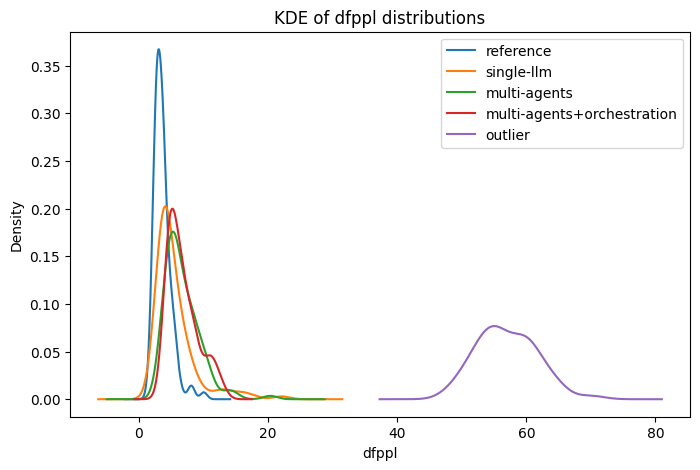

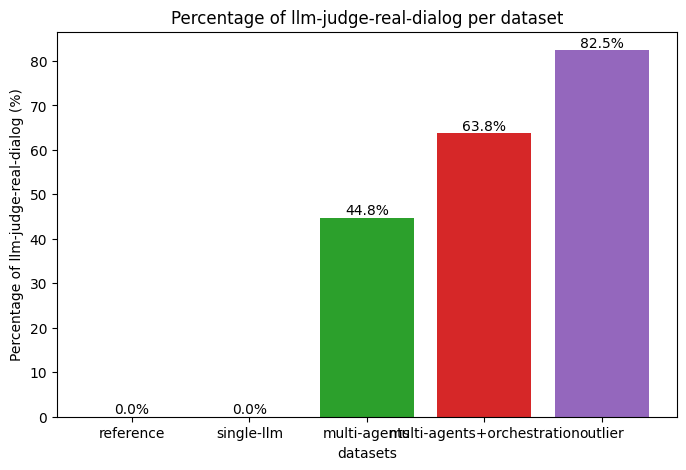

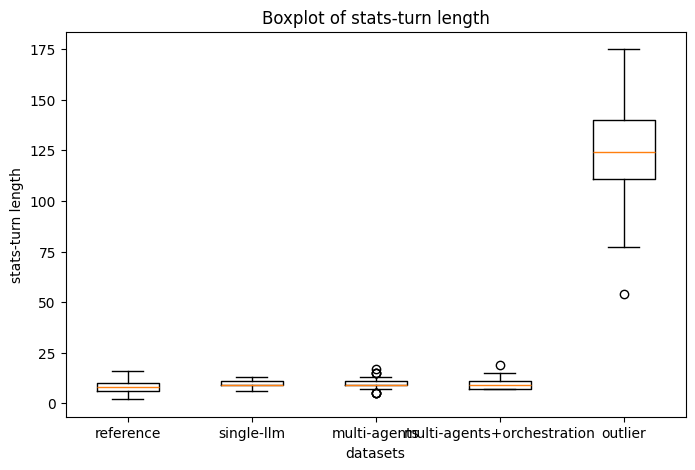

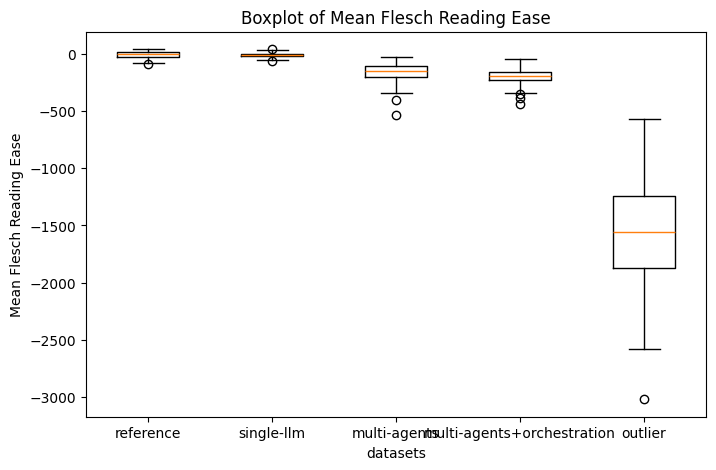

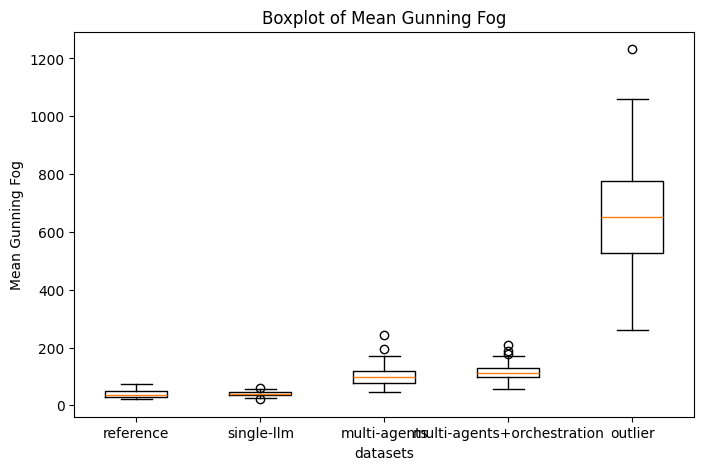